In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("Independent_Medical_Reviews.csv")

In [4]:
#cleanup the text, take out line breaks, punctuation and lowercase
def clean_text(text):
    text = re.sub(r'\n', ' ', str(text)) 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  
    text = text.lower().strip()  
    return text

df['Clean_Findings'] = df['Findings'].astype(str).apply(clean_text)

In [5]:
#encoder
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Determination'])  # 0 = Overturned, 1 = Upheld


In [6]:
# train test split
X = df['Clean_Findings']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
# TFIDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [8]:
# log reg
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [11]:
y_pred = model.predict(X_test_tfidf)
print("Results:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Results:
                                     precision    recall  f1-score   support

Overturned Decision of Health Plan       0.94      0.94      0.94      1691
    Upheld Decision of Health Plan       0.95      0.95      0.95      2158

                          accuracy                           0.95      3849
                         macro avg       0.94      0.94      0.94      3849
                      weighted avg       0.95      0.95      0.95      3849



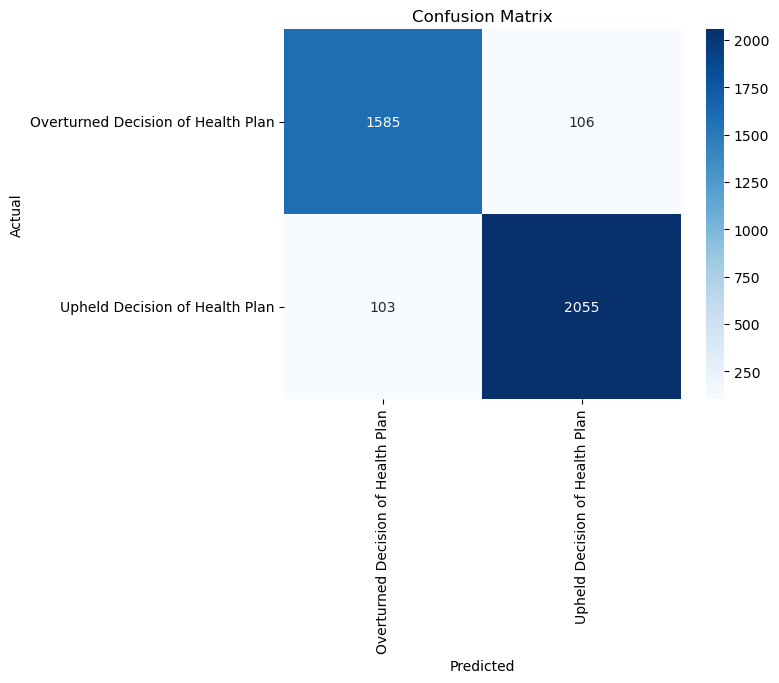

In [10]:
# conf matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

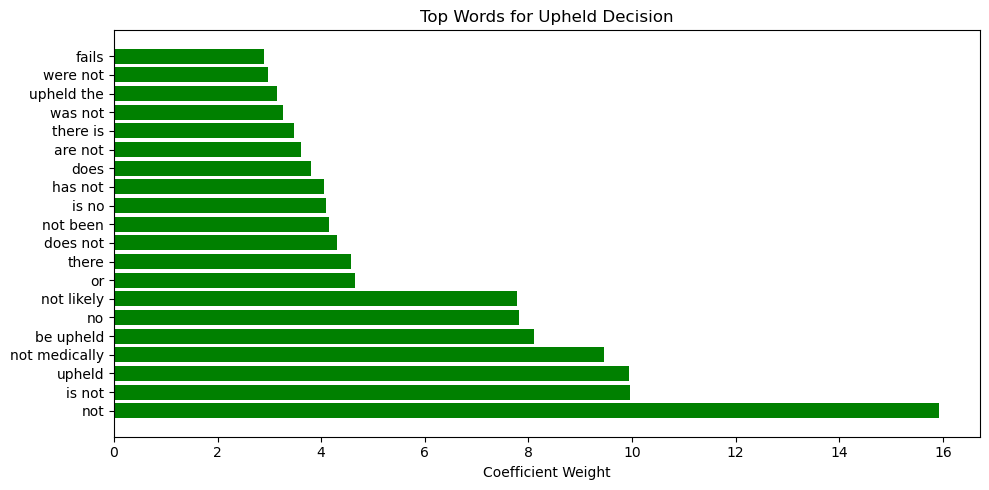

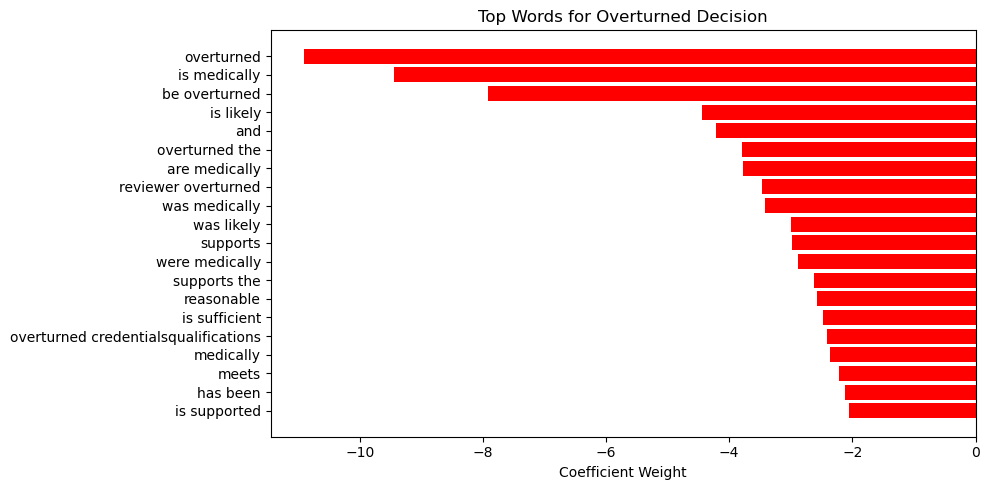

In [12]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = np.array(tfidf.get_feature_names_out())
coefficients = model.coef_[0]

# words to visualize
top_n = 20

# top pos and neg
top_upheld_idx = np.argsort(coefficients)[-top_n:]
top_overturned_idx = np.argsort(coefficients)[:top_n]

# extraction
top_upheld_words = feature_names[top_upheld_idx]
top_upheld_scores = coefficients[top_upheld_idx]

top_overturned_words = feature_names[top_overturned_idx]
top_overturned_scores = coefficients[top_overturned_idx]


def plot_words(words, scores, title, color):
    plt.figure(figsize=(10, 5))
    y_pos = np.arange(len(words))
    plt.barh(y_pos, scores, color=color)
    plt.yticks(y_pos, words)
    plt.xlabel('Coefficient Weight')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_words(top_upheld_words, top_upheld_scores, 'Top Words for Upheld Decision', 'green')
plot_words(top_overturned_words, top_overturned_scores, 'Top Words for Overturned Decision', 'red')
